# Examples

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/imartinezl/cpab/HEAD)

First, we need to import the necessary Python libraries: ``cpab`` library to compute the transformations, ``matplotlib`` for data visualization, ``numpy`` for array manipulation and ``pytorch`` for autodifferentiation and gradient descent optimization.

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cpab

plt.rcParams["figure.figsize"] = (10, 7)

In order to create a transformation, several options need to be specified. CPAB transformations are built by integrating a continuous piecewise affine velocity field. Such velocity field is defined onto a regular grid, or tesselation. For this example, we will set the number of intervals to 5 (``tess_size=5``)

In [3]:
tess_size = 5
backend = "numpy" # ["pytorch", "numpy"]
device = "cpu" # ["cpu", "gpu"]
zero_boundary = True # [True, False]
outsize = 100
batch_size = 1
basis = "qr" # ["svd", "sparse", "rref", "qr"]

T = cpab.Cpab(tess_size, backend, device, zero_boundary, basis)

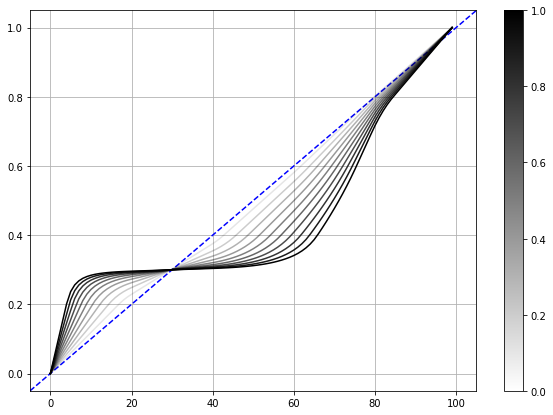

In [4]:
grid = T.uniform_meshgrid(outsize)
theta = T.identity(batch_size, epsilon=2)

plt.figure()
n = 11
plt.axline((0,0),(outsize,1), color="blue", ls="dashed")
for i in range(n):
    time = i / (n-1)
    grid_t = T.transform_grid(grid, theta, time=time)
    plt.plot(grid_t.T, label=round(time, 2), color="black", alpha=time)

plt.grid()
sm = plt.cm.ScalarMappable(cmap="gray_r")
plt.colorbar(sm);


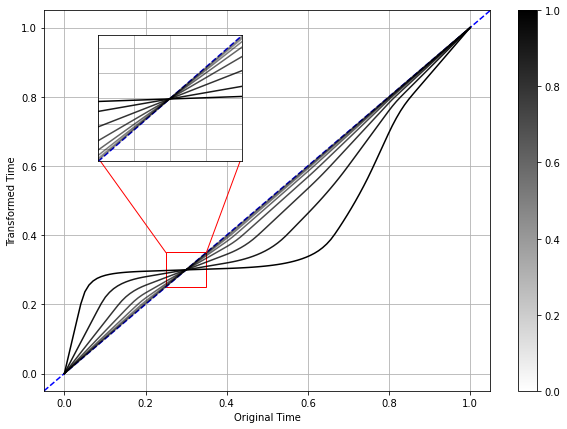

In [5]:
grid = T.uniform_meshgrid(outsize)
theta = T.identity(batch_size, epsilon=2)

fig, ax = plt.subplots()
ax_zoom = fig.add_axes([0.2,0.58,0.2,0.25])

ax.axline((0,0),(1,1), color="blue", ls="dashed")
ax_zoom.axline((0,0),(1,1), color="blue", ls="dashed")

N = 11
for i in range(N):
    alpha = i / (N-1)
    grid_t = T.transform_grid_ss(grid, theta / 2**N, N=i+1)
    ax.plot(grid, grid_t.T, label=round(time, 2), color="black", alpha=alpha)
    ax_zoom.plot(grid, grid_t.T, label=round(time, 2), color="black", alpha=alpha)

ax.grid()
ax.set_xlabel("Original Time")
ax.set_ylabel("Transformed Time")

sm = plt.cm.ScalarMappable(cmap="gray_r")
plt.colorbar(sm, ax=ax)

ax_zoom.grid()
ax_zoom.set_xlim(.25, .35)
ax_zoom.set_ylim(.25, .35)
ax_zoom.set_xticklabels([])
ax_zoom.set_yticklabels([])
ax_zoom.xaxis.set_ticks_position('none')
ax_zoom.yaxis.set_ticks_position('none')

from matplotlib.patches import Rectangle
import matplotlib.lines as lines
r = Rectangle((.25,.25), 0.1, 0.1, edgecolor="red", facecolor="none", lw=1)
ax.add_patch(r)

line = lines.Line2D([0.085,0.25], [0.62, 0.35], color="red", lw=1)
ax.add_line(line)
line = lines.Line2D([0.435,0.35], [0.62, 0.35], color="red", lw=1)
ax.add_line(line);



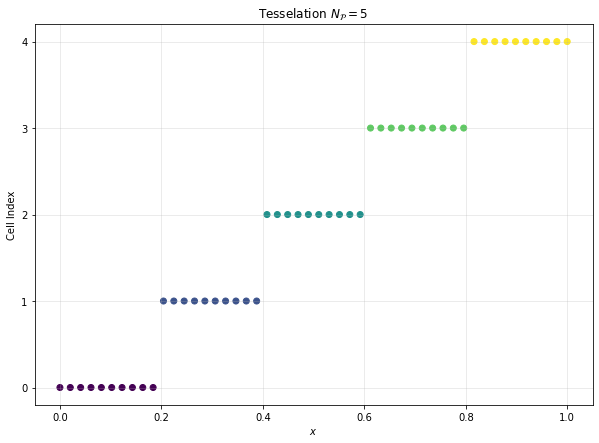

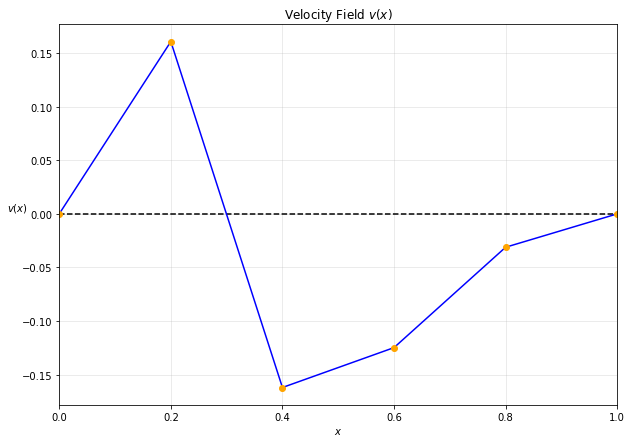

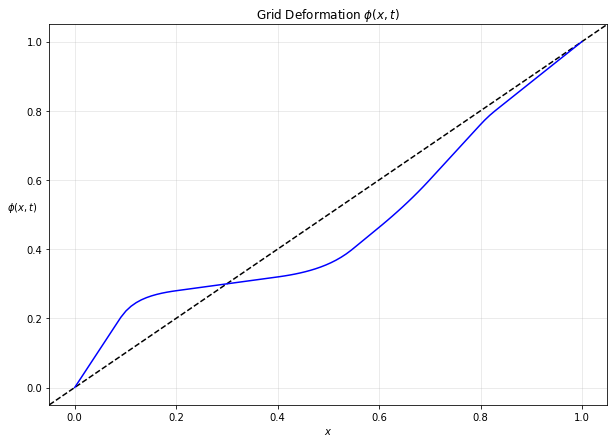

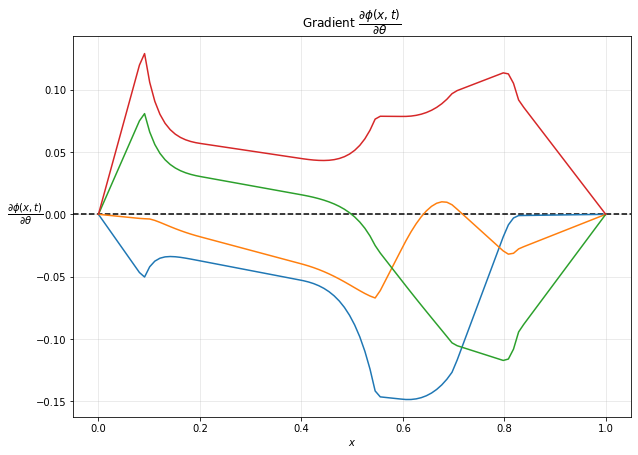

In [6]:
grid = T.uniform_meshgrid(outsize)
theta = T.sample_transformation(batch_size)
theta = T.sample_transformation_with_prior(batch_size)
theta = T.identity(batch_size, epsilon=1)
grid_t = T.transform_grid(grid, theta)


T.visualize_tesselation()
T.visualize_velocity(theta)
T.visualize_deformgrid(theta)
T.visualize_gradient(theta);

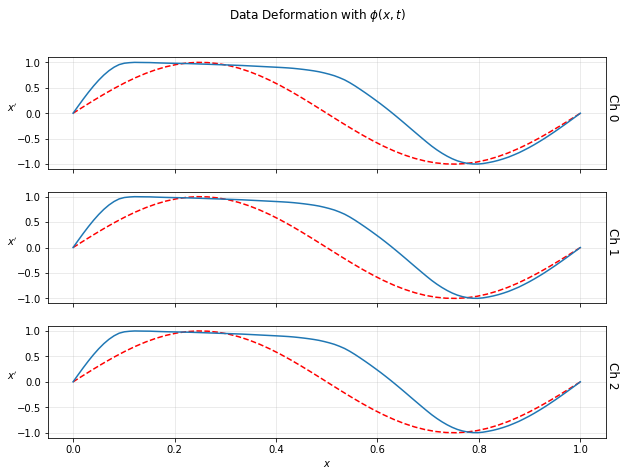

In [7]:
# Data Transform

width = 50
channels = 3

# Generation
# data = np.random.normal(0, 1, (batch_size, width, channels))
a = np.zeros((batch_size, channels))
b = np.ones((batch_size, channels)) * 2 * np.pi
noise = np.random.normal(0, 0.1, (batch_size, width, channels))
x = np.linspace(a, b, width, axis=1)
data = np.sin(x)
T.visualize_deformdata(data, theta);